In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from datetime import datetime
import seaborn as sns

## Load prepared data

In [151]:
df_2015 = pd.read_csv("loan_2015.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (49,70) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [152]:
pd.DataFrame(df_2015.columns.values).to_csv("2015featuresdetermined.txt", index=None, header=None)

In [153]:
# show empty values in each column
df_2015.isnull().sum()

percentbcgt75                     4239
mortacc                              0
numactvbctl                          0
term                                 0
openrv24m                       399723
memberid                        421095
secappopenacc                   421095
inqfi                           399723
openactil                       399723
ficorangelow                         0
revolbaljoint                   421095
numrevtlbalgt0                       0
ficorangehigh                        0
intrate                              0
numbcsats                            0
allutil                         399723
mosinrcnttl                          0
delinqamount                         0
homeownership                        0
initialliststatus                    0
dti                                  2
numoprevtl                           0
secapprevolutil                 421095
inqlast12m                      399723
numactvrevtl                         0
secappcollections12mthsex

## Data cleaning

In [154]:
df_2015_shape = df_2015.shape
print(df_2015_shape)

(421095, 108)


In [155]:
# record columns that all values are nan
empty_columns = []
for column in list(df_2015.columns):
    if df_2015[column].isnull().sum() == df_2015_shape[0]:
        empty_columns.append(column)

In [156]:
empty_columns

['memberid',
 'secappopenacc',
 'revolbaljoint',
 'secapprevolutil',
 'secappcollections12mthsexmed',
 'secappficorangelow',
 'secappopenactil',
 'secappmortacc',
 'secappinqlast6mths',
 'secappchargeoffwithin12mths',
 'secappmthssincelastmajorderog',
 'secappnumrevaccts',
 'secappearliestcrline',
 'secappficorangehigh']

In [157]:
# drop empty columns
for column in empty_columns:
    df_2015.drop(column, axis=1, inplace=True)

In [158]:
# only keep Fully paid and Charged off data
df_2015 = df_2015[(df_2015.loanstatus =="Fully Paid") | (df_2015.loanstatus == "Charged Off")]

In [159]:
df_2015_shape = df_2015.shape
print(df_2015_shape)

(341460, 94)


In [160]:
# divide train and test based on month of the year: 1~9 train 10~12 test
issued=list(df_2015['issued'].unique())
issued

['Dec-2015',
 'Nov-2015',
 'Oct-2015',
 'Sep-2015',
 'Aug-2015',
 'Jul-2015',
 'Jun-2015',
 'May-2015',
 'Apr-2015',
 'Mar-2015',
 'Feb-2015',
 'Jan-2015']

In [161]:
# label issued data flag test: 1, train: 0
df_2015['train_flg'] = df_2015.issued.apply(lambda x: 0 if x in issued[:3] else 1)
df_2015.train_flg.value_counts()

1    253485
0     87975
Name: train_flg, dtype: int64

In [162]:
# convert issue date to month only
df_2015["issued"] = pd.to_datetime(df_2015["issued"], format = "%b-%Y")
df_2015["issued"] = df_2015.issued.dt.month

In [163]:
print(df_2015["issued"].value_counts())

7     39935
10    36372
1     31476
4     31034
8     30726
5     28037
12    27744
6     24801
9     23955
11    23859
3     22347
2     21174
Name: issued, dtype: int64


In [164]:
# convert interest rate from string to float
df_2015["intrate"] = df_2015["intrate"].str.replace("%", "")
df_2015["intrate"] = df_2015["intrate"].astype("float") / 100.0

In [165]:
# only keep 36 months term
df_2015 = df_2015[df_2015.term == " 36 months"]

In [166]:
df_2015.drop("term", axis=1, inplace=True)

In [167]:
# have an idea of numerical feature and object feature
num_col = []
ob_col = []
for column in list(df_2015.columns):
    if df_2015[column].dtypes in ["float64", "int64"]:
        num_col.append(column)
    if df_2015[column].dtypes == "object":
        ob_col.append(column)
        
print(len(num_col), len(ob_col), df_2015.shape)

77 17 (258283, 94)


In [168]:
# have an idea of all object values
for column in ob_col:
    print("####################")
    print("Value counts for: ", column)
    print(df_2015[column].value_counts())
    print("missing values", df_2015[column].isnull().sum())

####################
Value counts for:  homeownership
MORTGAGE    118580
RENT        110975
OWN          28728
Name: homeownership, dtype: int64
missing values 0
####################
Value counts for:  initialliststatus
w    147901
f    110382
Name: initialliststatus, dtype: int64
missing values 0
####################
Value counts for:  revolutil
0%        860
53%       609
58%       590
62%       588
54%       581
60%       580
57%       579
50%       577
52%       572
44%       572
55%       571
49%       570
51%       568
59%       567
47%       556
43%       555
61%       554
56%       549
48%       548
39%       546
38%       545
63%       536
42%       528
68%       526
46%       525
37%       523
45%       522
66%       515
41%       511
64%       510
         ... 
116.1%      1
124.7%      1
109.4%      1
131.8%      1
122.8%      1
107.4%      1
110.6%      1
105.6%      1
112.3%      1
116%        1
119.1%      1
136.1%      1
113.7%      1
119.6%      1
107.5%      1
123.3% 

945xx    2907
112xx    2788
750xx    2728
606xx    2658
300xx    2456
900xx    2233
331xx    2233
100xx    2196
770xx    2180
891xx    2119
070xx    2098
330xx    1928
917xx    1869
104xx    1793
117xx    1703
921xx    1658
852xx    1592
926xx    1526
913xx    1483
113xx    1458
334xx    1452
481xx    1437
925xx    1402
600xx    1352
604xx    1350
021xx    1339
601xx    1338
920xx    1326
802xx    1322
956xx    1287
         ... 
506xx       2
098xx       2
835xx       1
929xx       1
834xx       1
837xx       1
527xx       1
942xx       1
817xx       1
509xx       1
649xx       1
849xx       1
862xx       1
203xx       1
522xx       1
510xx       1
702xx       1
507xx       1
892xx       1
097xx       1
838xx       1
709xx       1
969xx       1
771xx       1
520xx       1
504xx       1
007xx       1
821xx       1
501xx       1
204xx       1
Name: zipcode, Length: 899, dtype: int64
missing values 0
####################
Value counts for:  disbursementmethod
Cash    258283
Name: disburse

In [169]:
df_2015["revolutil"]

1         41.7%
2         33.2%
3            3%
6         52.3%
8         76.6%
12        32.6%
17        11.7%
18        68.4%
20        34.6%
25        35.2%
26        56.3%
27        19.2%
30          69%
33        21.2%
34        35.5%
35        63.1%
36        36.6%
39        28.7%
42        17.2%
44          83%
45        35.2%
47        34.4%
51        52.5%
58        21.4%
60          46%
61        84.5%
62        77.4%
68        59.4%
75        67.2%
76        20.1%
          ...  
421048    64.1%
421049    19.5%
421053    46.1%
421055    62.5%
421057    58.2%
421058    36.4%
421059    38.2%
421061    10.2%
421062    90.5%
421064    53.1%
421065    63.4%
421067    92.3%
421068      98%
421070    24.9%
421072    78.9%
421077    30.6%
421078    63.2%
421079    73.4%
421081    34.7%
421082    27.1%
421083    25.8%
421084    97.6%
421085     5.6%
421086    43.9%
421087    41.6%
421088    69.7%
421089      65%
421090    82.1%
421091    84.5%
421094    79.8%
Name: revolutil, Length:

In [170]:
# feature revolutil convert to float
df_2015["revolutil"] = df_2015["revolutil"].str.replace("%", "")
df_2015["revolutil"] = df_2015["revolutil"].astype("float") / 100.0

In [171]:
# feature disbursementmethod only one type, drop it
df_2015.drop("disbursementmethod", axis=1, inplace=True)

In [172]:
# fill description with NaN with 0
df_2015["desc"].fillna(0, inplace=True)
# who write at list one word with 1
df_2015.loc[df_2015["desc"] != 0, "desc"] = 1

In [173]:
df_2015["earliestcrline"]

1         Sep-2006
2         Mar-2001
3         May-1991
6         May-2002
8         Nov-2001
12        Apr-2003
17        Nov-2009
18        Oct-1987
20        Sep-2006
25        Nov-2001
26        Jan-2002
27        Dec-1999
30        Jun-2005
33        Dec-1987
34        Jan-1998
35        May-2000
36        Jul-2004
39        Apr-1994
42        Sep-2007
44        Nov-2002
45        Aug-2004
47        May-2001
51        Oct-2004
58        Apr-1993
60        Mar-2005
61        Jun-1990
62        Aug-2008
68        Jun-1996
75        Jun-1996
76        Apr-2005
            ...   
421048    Nov-2003
421049    Apr-1996
421053    Sep-1984
421055    May-2002
421057    Apr-1994
421058    Dec-1993
421059    Nov-2002
421061    May-1986
421062    Oct-2003
421064    Mar-1998
421065    Aug-1990
421067    Jun-1996
421068    Dec-2006
421070    Jun-1993
421072    Jun-2001
421077    Oct-1994
421078    Sep-2003
421079    Oct-2006
421081    Mar-2000
421082    Nov-2006
421083    Nov-1975
421084    Fe

In [174]:
# earliest credit line convert to how many months to 2015-12
df_2015["earliestcrline"] = pd.to_datetime(df_2015["earliestcrline"], format = "%b-%Y")
FMT = '%Y-%m-%d'
df_2015["earliestcrline"] = ((datetime.strptime("2015-12-01", FMT) - df_2015["earliestcrline"]) / np.timedelta64(1, 'M')).astype("int")

In [175]:
df_2015['emplength']

1           4 years
2           5 years
3           9 years
6           2 years
8         10+ years
12          9 years
17          2 years
18          4 years
20          4 years
25          3 years
26          6 years
27        10+ years
30         < 1 year
33              NaN
34         < 1 year
35          2 years
36          5 years
39         < 1 year
42          4 years
44        10+ years
45        10+ years
47         < 1 year
51          3 years
58              NaN
60          8 years
61        10+ years
62          3 years
68          8 years
75          3 years
76        10+ years
            ...    
421048      5 years
421049      9 years
421053    10+ years
421055      9 years
421057      4 years
421058     < 1 year
421059    10+ years
421061      4 years
421062      3 years
421064      2 years
421065    10+ years
421067    10+ years
421068     < 1 year
421070          NaN
421072    10+ years
421077    10+ years
421078      9 years
421079      4 years
421081       1 year


In [176]:
# emplength label encoding
df_2015['emplength'].replace('n/a', np.nan, inplace=True)
df_2015['emplength'].replace('< 1 year', '0', inplace=True)
df_2015['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df_2015.emplength.fillna(value=-999,inplace=True)
df_2015['emplength'] = df_2015['emplength'].astype(int)

In [177]:
df_2015.emplength.value_counts()

 10     81561
 2      23807
 0      21917
 3      21120
 1      17619
-999    16976
 5      15457
 4      15287
 8      13062
 7      11239
 6      10231
 9      10007
Name: emplength, dtype: int64

In [178]:
# dealing with first credit model grade, label encoding
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

df_2015.grade = df_2015.grade.map(Dic_grade)

In [179]:
# dealing with grade associated subgrade, label encoding
df_2015.subgrade = df_2015.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [180]:
# convert zipcode first three digits to int
df_2015.zipcode = df_2015.zipcode.apply(lambda x: (x[0:3]))

In [181]:
# zipcode frequency encoding
zipcode_freq = df_2015.groupby("zipcode").size().reset_index()
zipcode_freq.columns = ["zipcode", "zipcode_freq"]
df_2015=pd.merge(df_2015, zipcode_freq, how="left", on="zipcode")

In [182]:
zipcode_freq.to_csv("zipcode_freq.txt")

In [183]:
# all titles to lowercase
df_2015["emptitle"] = df_2015["emptitle"].apply(lambda x: str(x).lower())

In [184]:
# emptitle frequency encoding
emptitle_freq = df_2015.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df_2015 = pd.merge(df_2015, emptitle_freq, how="left", on="emptitle")

In [185]:
emptitle_freq.to_csv("emptitle_freq.txt")

In [186]:
df_2015["emptitle"].isnull().sum()

0

In [187]:
# map loan status to "Charged Off": 1, "Fully Paid": 0
df_2015['loanstatus'] = df_2015.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})
print(df_2015.loanstatus.value_counts())
print(df_2015.loanstatus.value_counts(normalize=True))

0    217335
1     40948
Name: loanstatus, dtype: int64
0    0.841461
1    0.158539
Name: loanstatus, dtype: float64


In [188]:
# revisit col features 
num_col = []
ob_col = []
for column in list(df_2015.columns):
    if df_2015[column].dtypes in ["float64", "int64"]:
        num_col.append(column)
    if df_2015[column].dtypes == "object":
        ob_col.append(column)

In [189]:
for column in ob_col:
    print("####################")
    print("Value counts for: ", column)
    print("Different values: ", len(df_2015[column].value_counts().index))
    print("missing values", df_2015[column].isnull().sum())

####################
Value counts for:  homeownership
Different values:  3
missing values 0
####################
Value counts for:  initialliststatus
Different values:  2
missing values 0
####################
Value counts for:  emptitle
Different values:  68113
missing values 0
####################
Value counts for:  zipcode
Different values:  899
missing values 0
####################
Value counts for:  verificationstatusjoint
Different values:  1
missing values 258116
####################
Value counts for:  purpose
Different values:  14
missing values 0
####################
Value counts for:  applicationtype
Different values:  2
missing values 0
####################
Value counts for:  verificationstatus
Different values:  3
missing values 0
####################
Value counts for:  addrstate
Different values:  49
missing values 0


## One hot encoding

In [190]:
df_2015.shape

(258283, 95)

In [191]:
dummy_feature = ["homeownership", "verificationstatus", "applicationtype", "purpose", "initialliststatus"]

In [192]:
# get dummy
df_dummy = pd.get_dummies(df_2015[dummy_feature])

In [193]:
OHE_feature=list(df_dummy.columns.values)

In [194]:
df_2015=pd.concat([df_2015,df_dummy], axis=1)

In [195]:
pd.DataFrame(list(df_2015.columns)).to_csv("featuresafterohcoding.txt", header=None, index=None)

In [196]:
df_2015.shape

(258283, 119)

In [197]:
df_2015.drop(dummy_feature, axis=1, inplace=True)

In [198]:
df_2015.shape

(258283, 114)

In [199]:
list(df_2015.columns)

['percentbcgt75',
 'mortacc',
 'numactvbctl',
 'openrv24m',
 'inqfi',
 'openactil',
 'ficorangelow',
 'numrevtlbalgt0',
 'ficorangehigh',
 'intrate',
 'numbcsats',
 'allutil',
 'mosinrcnttl',
 'delinqamount',
 'dti',
 'numoprevtl',
 'inqlast12m',
 'numactvrevtl',
 'id',
 'numtl120dpd2m',
 'numtl30dpd',
 'revolutil',
 'annualinc',
 'earliestcrline',
 'totalcutl',
 'numsats',
 'emplength',
 'emptitle',
 'avgcurbal',
 'annualincjoint',
 'openil24m',
 'numtl90gdpd24m',
 'taxliens',
 'mthssincelastmajorderog',
 'pubrecbankruptcies',
 'fundedamount',
 'accnowdelinq',
 'totalrevhilim',
 'desc',
 'dtijoint',
 'grade',
 'pcttlnvrdlq',
 'maxbalbc',
 'zipcode',
 'mosinoldrevtlop',
 'mosinrcntrevtlop',
 'mthssincerecentbc',
 'mthssincerecentbcdlq',
 'loanamount',
 'numiltl',
 'openil12m',
 'mthssincerecentinq',
 'collections12mthsexmed',
 'accopenpast24mths',
 'verificationstatusjoint',
 'revolbal',
 'tothicredlim',
 'totalbalil',
 'openacc6m',
 'numbctl',
 'totalbalexmort',
 'chargeoffwithin12mth

In [200]:
# revisit col features 
num_col = []
ob_col = []
for column in list(df_2015.columns):
    if df_2015[column].dtypes in ["float64", "int64"]:
        num_col.append(column)
    if df_2015[column].dtypes == "object":
        ob_col.append(column)

In [201]:
for column in ob_col:
    print("####################")
    print("Value counts for: ", column)
    print("Different values: ", len(df_2015[column].value_counts().index))
    print("missing values", df_2015[column].isnull().sum())

####################
Value counts for:  emptitle
Different values:  68113
missing values 0
####################
Value counts for:  zipcode
Different values:  899
missing values 0
####################
Value counts for:  verificationstatusjoint
Different values:  1
missing values 258116
####################
Value counts for:  addrstate
Different values:  49
missing values 0


In [202]:
# drop verificationstatusjoint
df_2015.drop("verificationstatusjoint", inplace=True, axis=1)

# Label encoding

In [203]:
label_feature = ["emptitle", "addrstate"]

In [204]:
from sklearn.preprocessing import LabelEncoder

for column in label_feature:
    le = LabelEncoder()
    df_2015[column] = le.fit_transform(df_2015[column])

In [77]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_2015["emptitle"] = le.fit(df_2015["emptitle"])

In [78]:
np.save('emptitle_classes.npy', le.classes_)

In [142]:
list(le.classes_)

[' \tadv mtr proj fld rep',
 '   day care proivder',
 '  carpenter ',
 '  director',
 '  electronics manager ',
 '  elevator clearance operator ',
 '  lead caterer',
 ' ac tech',
 ' acc manager',
 ' accounting  manager',
 ' administration assistant ',
 ' advance cnn ',
 ' afjrotc teacher',
 ' aftermarket expeditor',
 ' ambulatory rn clinic supervisor',
 ' and planned director of major gifts',
 ' appraisal coordinator',
 ' area leader',
 ' assembler',
 ' assistant manager',
 ' assistant teacher',
 ' assistant vice president',
 ' assitant director',
 ' associate professor',
 ' asst. site director',
 ' automotive technician',
 ' avp, private client support',
 ' banker',
 ' barber',
 ' bi reports developer',
 ' building engineer ',
 ' building maintenance tech',
 ' buisness development director- spa ',
 ' business analyst',
 ' capital account manager',
 ' carrier',
 ' case managerr',
 ' cash management team leader',
 ' cashier',
 ' ccht dialsys tech',
 ' ceo',
 ' certified professional cod

## Determine features

In [205]:
features = list(df_2015.columns)

In [206]:
features.remove("id")

In [207]:
features.remove("loanstatus")

In [208]:
features.remove("issued")

In [49]:
pd.DataFrame(features, columns=["features"]).to_csv("determinedfeatures.csv")

In [217]:
features

['percentbcgt75',
 'mortacc',
 'numactvbctl',
 'openrv24m',
 'inqfi',
 'openactil',
 'ficorangelow',
 'numrevtlbalgt0',
 'ficorangehigh',
 'intrate',
 'numbcsats',
 'allutil',
 'mosinrcnttl',
 'delinqamount',
 'dti',
 'numoprevtl',
 'inqlast12m',
 'numactvrevtl',
 'numtl120dpd2m',
 'numtl30dpd',
 'revolutil',
 'annualinc',
 'earliestcrline',
 'totalcutl',
 'numsats',
 'emplength',
 'emptitle',
 'avgcurbal',
 'annualincjoint',
 'openil24m',
 'numtl90gdpd24m',
 'taxliens',
 'mthssincelastmajorderog',
 'pubrecbankruptcies',
 'fundedamount',
 'accnowdelinq',
 'totalrevhilim',
 'desc',
 'dtijoint',
 'grade',
 'pcttlnvrdlq',
 'maxbalbc',
 'zipcode',
 'mosinoldrevtlop',
 'mosinrcntrevtlop',
 'mthssincerecentbc',
 'mthssincerecentbcdlq',
 'loanamount',
 'numiltl',
 'openil12m',
 'mthssincerecentinq',
 'collections12mthsexmed',
 'accopenpast24mths',
 'revolbal',
 'tothicredlim',
 'totalbalil',
 'openacc6m',
 'numbctl',
 'totalbalexmort',
 'chargeoffwithin12mths',
 'mthssincelastdelinq',
 'mthss

## XgBoost pre training

In [209]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [210]:
df_train = df_2015.query("train_flg == 1")
df_test = df_2015.query("train_flg == 0")

In [213]:
list(df_train.columns)

['percentbcgt75',
 'mortacc',
 'numactvbctl',
 'openrv24m',
 'inqfi',
 'openactil',
 'ficorangelow',
 'numrevtlbalgt0',
 'ficorangehigh',
 'intrate',
 'numbcsats',
 'allutil',
 'mosinrcnttl',
 'delinqamount',
 'dti',
 'numoprevtl',
 'inqlast12m',
 'numactvrevtl',
 'id',
 'numtl120dpd2m',
 'numtl30dpd',
 'revolutil',
 'annualinc',
 'earliestcrline',
 'totalcutl',
 'numsats',
 'emplength',
 'emptitle',
 'avgcurbal',
 'annualincjoint',
 'openil24m',
 'numtl90gdpd24m',
 'taxliens',
 'mthssincelastmajorderog',
 'pubrecbankruptcies',
 'fundedamount',
 'accnowdelinq',
 'totalrevhilim',
 'desc',
 'dtijoint',
 'grade',
 'pcttlnvrdlq',
 'maxbalbc',
 'zipcode',
 'mosinoldrevtlop',
 'mosinrcntrevtlop',
 'mthssincerecentbc',
 'mthssincerecentbcdlq',
 'loanamount',
 'numiltl',
 'openil12m',
 'mthssincerecentinq',
 'collections12mthsexmed',
 'accopenpast24mths',
 'revolbal',
 'tothicredlim',
 'totalbalil',
 'openacc6m',
 'numbctl',
 'totalbalexmort',
 'chargeoffwithin12mths',
 'mthssincelastdelinq',


In [69]:
df_2015.to_csv("cleaneddata12042018.csv")

In [214]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[features], df_train.loanstatus, 
                                                      test_size=0.3, random_state=2015, stratify = df_train.loanstatus )

In [222]:
X_train.shape

(135477, 110)

In [220]:
list(X_train.columns)

['percentbcgt75',
 'mortacc',
 'numactvbctl',
 'openrv24m',
 'inqfi',
 'openactil',
 'ficorangelow',
 'numrevtlbalgt0',
 'ficorangehigh',
 'intrate',
 'numbcsats',
 'allutil',
 'mosinrcnttl',
 'delinqamount',
 'dti',
 'numoprevtl',
 'inqlast12m',
 'numactvrevtl',
 'numtl120dpd2m',
 'numtl30dpd',
 'revolutil',
 'annualinc',
 'earliestcrline',
 'totalcutl',
 'numsats',
 'emplength',
 'emptitle',
 'avgcurbal',
 'annualincjoint',
 'openil24m',
 'numtl90gdpd24m',
 'taxliens',
 'mthssincelastmajorderog',
 'pubrecbankruptcies',
 'fundedamount',
 'accnowdelinq',
 'totalrevhilim',
 'desc',
 'dtijoint',
 'grade',
 'pcttlnvrdlq',
 'maxbalbc',
 'zipcode',
 'mosinoldrevtlop',
 'mosinrcntrevtlop',
 'mthssincerecentbc',
 'mthssincerecentbcdlq',
 'loanamount',
 'numiltl',
 'openil12m',
 'mthssincerecentinq',
 'collections12mthsexmed',
 'accopenpast24mths',
 'revolbal',
 'tothicredlim',
 'totalbalil',
 'openacc6m',
 'numbctl',
 'totalbalexmort',
 'chargeoffwithin12mths',
 'mthssincelastdelinq',
 'mthss

In [53]:
X_test, y_test = df_test[features], df_test.loanstatus

In [54]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

In [55]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.632, 
          "colsample_bytree": 0.7,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1234, 
          "eval_metric": "auc",
          #"gamma": 1, 
          "min_child_weight": 5} 

In [56]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,\
  early_stopping_rounds= 50)

[0]	train-auc:0.686336	eval-auc:0.681396
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.696903	eval-auc:0.689115
[2]	train-auc:0.699016	eval-auc:0.692176
[3]	train-auc:0.700701	eval-auc:0.692989
[4]	train-auc:0.701826	eval-auc:0.693466
[5]	train-auc:0.702767	eval-auc:0.694513
[6]	train-auc:0.703744	eval-auc:0.695447
[7]	train-auc:0.7046	eval-auc:0.696309
[8]	train-auc:0.705319	eval-auc:0.696326
[9]	train-auc:0.705892	eval-auc:0.696931
[10]	train-auc:0.708125	eval-auc:0.698653
[11]	train-auc:0.708528	eval-auc:0.698591
[12]	train-auc:0.708833	eval-auc:0.698959
[13]	train-auc:0.70918	eval-auc:0.698971
[14]	train-auc:0.709411	eval-auc:0.699308
[15]	train-auc:0.70973	eval-auc:0.699512
[16]	train-auc:0.710203	eval-auc:0.699592
[17]	train-auc:0.710722	eval-auc:0.699797
[18]	train-auc:0.711032	eval-auc:0.70015
[19]	train-auc:0.711332	eval-auc:0.700231
[20]	train-auc:0.711658	eval-auc:0

[192]	train-auc:0.767544	eval-auc:0.710709
[193]	train-auc:0.767848	eval-auc:0.710709
[194]	train-auc:0.768033	eval-auc:0.71069
[195]	train-auc:0.768254	eval-auc:0.710668
[196]	train-auc:0.768486	eval-auc:0.710691
[197]	train-auc:0.768658	eval-auc:0.710745
[198]	train-auc:0.768939	eval-auc:0.710782
[199]	train-auc:0.769214	eval-auc:0.710855
[200]	train-auc:0.769306	eval-auc:0.71082
[201]	train-auc:0.769536	eval-auc:0.710801
[202]	train-auc:0.769631	eval-auc:0.710813
[203]	train-auc:0.7697	eval-auc:0.710837
[204]	train-auc:0.769899	eval-auc:0.71084
[205]	train-auc:0.770148	eval-auc:0.710794
[206]	train-auc:0.770528	eval-auc:0.710754
[207]	train-auc:0.770639	eval-auc:0.710724
[208]	train-auc:0.770756	eval-auc:0.710667
[209]	train-auc:0.77112	eval-auc:0.710723
[210]	train-auc:0.771358	eval-auc:0.710732
[211]	train-auc:0.771367	eval-auc:0.710725
[212]	train-auc:0.771609	eval-auc:0.710655
[213]	train-auc:0.771763	eval-auc:0.710645
[214]	train-auc:0.772037	eval-auc:0.710671
[215]	train-auc:0

In [57]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print("Area under the ROC curve - validation: %f" % roc_auc)
    print("Area under the ROC curve - train: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - test(AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - train (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()

Area under the ROC curve - validation: 0.711143
Area under the ROC curve - train: 0.777134
Area under the ROC curve - test: 0.716223


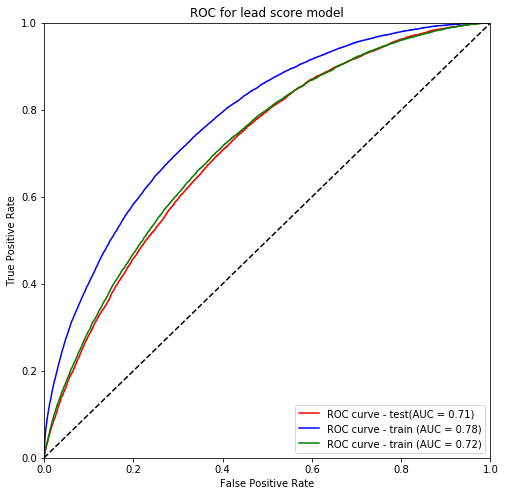

In [58]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

## Predicted values

In [59]:
y_pred = gbm.predict(dtest)

In [60]:
y_pred

array([0.12873551, 0.06013906, 0.04203024, ..., 0.05133136, 0.12959221,
       0.18961482], dtype=float32)

## Feature importance

In [61]:
importance=gbm.get_fscore()
importance

{'intrate': 336,
 'grade': 28,
 'subgrade': 138,
 'emplength': 175,
 'mthssincerecentrevoldelinq': 145,
 'bcutil': 340,
 'ficorangelow': 248,
 'dti': 532,
 'mthssincelastrecord': 250,
 'numtloppast12m': 95,
 'mthssincerecentbcdlq': 160,
 'zipcode': 328,
 'homeownership_RENT': 71,
 'emptitle_freq': 328,
 'earliestcrline': 310,
 'numoprevtl': 87,
 'bcopentobuy': 364,
 'totalacc': 133,
 'numactvrevtl': 101,
 'totalilhighcreditlimit': 244,
 'installment': 356,
 'mosinoldilacct': 414,
 'numbcsats': 106,
 'totalrevhilim': 321,
 'mthssincerecentbc': 285,
 'revolutil': 316,
 'mortacc': 107,
 'avgcurbal': 390,
 'accopenpast24mths': 250,
 'annualinc': 315,
 'totcollamt': 88,
 'verificationstatus_Not Verified': 24,
 'pcttlnvrdlq': 164,
 'percentbcgt75': 120,
 'mosinoldrevtlop': 361,
 'totalbclimit': 229,
 'revolbal': 308,
 'numrevtlbalgt0': 102,
 'ficorangehigh': 60,
 'numtl90gdpd24m': 8,
 'mthssincelastmajorderog': 183,
 'mthssincerecentinq': 279,
 'addrstate': 227,
 'homeownership_MORTGAGE': 45

In [62]:
df_importance = pd.DataFrame.from_dict(importance, orient="index", columns=["weight"])

In [63]:
df_importance.sort_values(['weight'], ascending=False, inplace=True)
df_importance['weight'] = df_importance['weight'] / df_importance['weight'].sum()

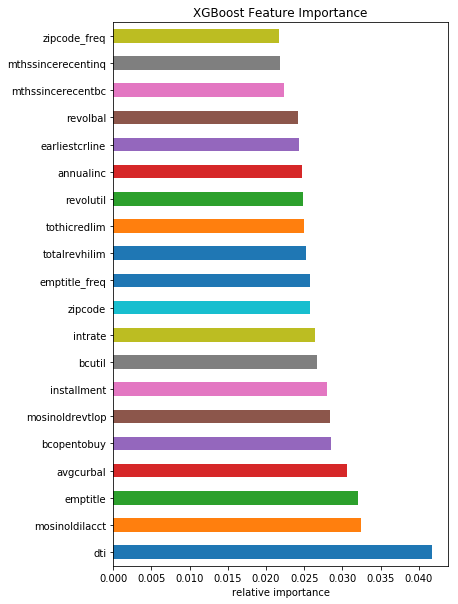

In [64]:
# df_importance.plot()
df_importance[:20].plot(kind='barh', y='weight', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

Text(0.5,0,'relative importance')

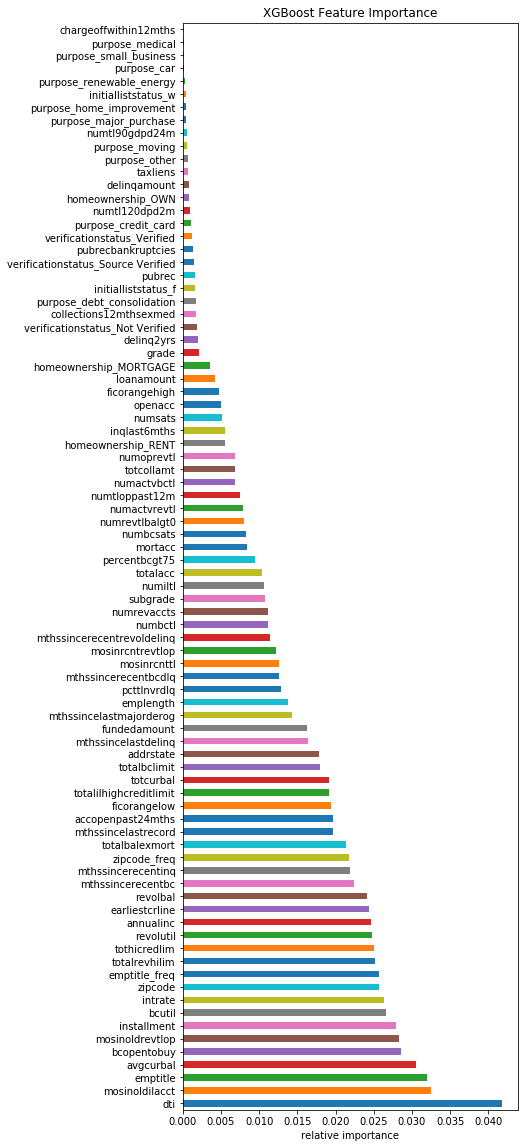

In [65]:
# df_importance.plot()
df_importance.plot(kind='barh', y='weight', legend=False, figsize=(6, 20))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

## Save model

In [66]:
import pickle

In [67]:
with open('model.pkl', 'wb') as outfile:
  
    pickle.dump(gbm, outfile)

In [68]:
from sklearn.externals import joblib
joblib.dump(gbm, "pregbm.joblib")

['pregbm.joblib']

In [221]:
df_importance

NameError: name 'df_importance' is not defined